# Подключение библиотек

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Подгрузка базы данных:

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Diabet.csv to Diabet.csv


# Работа с базой данных:

In [3]:
dataframe = pd.read_csv('Diabet.csv')
dataframe

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Исходная база данных содержит 768 строк с набором данных, разбитых по 9 столбцам (наборам признаков):

In [4]:
dataframe.shape
print('Размерность: ', dataframe.shape)

Размерность:  (768, 9)


Для примера рассмотрим первые несколько строчек:

In [5]:
dataframe.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Как видно из таблицы выше, нас интересует столбец "Outcome", который принимает следующие значения:
1.   "0" - в случае, если пациент здоров
2.   "1" - в случае подтвержденного диагноза "Диабет"

Разобьем имеющуюся базу данных на 2 части: обучающие и валидационные наборы данных



In [6]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Используется %d для тестирования и %d для валидации"
    % (len(train_dataframe), len(val_dataframe))
)

Используется 614 для тестирования и 154 для валидации


Преобразуем dataframe в dataset

In [7]:
def dataframe_to_dataset(dataframe):
  dataframe = dataframe.copy()
  labels = dataframe.pop("Outcome")
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  ds = ds.shuffle(buffer_size=len(dataframe))
  return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)


In [8]:
for x,y in train_ds.take(1):
    print("Input:",x)
    print("Outcome:",y)


Input: {'Pregnancies': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Glucose': <tf.Tensor: shape=(), dtype=int64, numpy=138>, 'BloodPressure': <tf.Tensor: shape=(), dtype=int64, numpy=60>, 'SkinThickness': <tf.Tensor: shape=(), dtype=int64, numpy=35>, 'Insulin': <tf.Tensor: shape=(), dtype=int64, numpy=167>, 'BMI': <tf.Tensor: shape=(), dtype=float64, numpy=34.6>, 'DiabetesPedigreeFunction': <tf.Tensor: shape=(), dtype=float64, numpy=0.534>, 'Age': <tf.Tensor: shape=(), dtype=int64, numpy=21>}
Outcome: tf.Tensor(1, shape=(), dtype=int64)


Разделим весь объем исходных данных на небольшие пакеты данных одной итерации (батчи)

In [9]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

# Препроцессинг данных

In [10]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

def encode_numerical_feature(feature,name,dataset):
  #Create a Normalization layer for our feature
  normalizer = Normalization()

  #Prepare a Dataset that only yeilds our feature
  feature_ds = dataset.map(lambda x,y: x[name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

  #Learn the statistics of the data
  normalizer.adapt(feature_ds)

  #Normalize the input feature
  encoded_feature = normalizer(feature)
  return encoded_feature

def encode_categorical_feature(feature,name,dataset, is_string):
  lookup_class = StringLookup if is_string else IntegerLookup

  #Create a lookup layer which will turn strings into integer indices
  lookup = lookup_class(outcome_mode="binary")

  #Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x,y: x[name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dim(x,-1))

  #Learn a set of possible string values and assign them a fixed integer index
  lookup.adapt(feature_ds)

  #Turn the string input into integer indices
  encoded_feature = lookup(feature)
  return encoded_feature

# Построение модели

In [11]:
Pregnancies = keras.Input(shape=(1,), name="Pregnancies")
Glucose = keras.Input(shape=(1,), name="Glucose")
BloodPressure = keras.Input(shape=(1,), name="BloodPressure")
SkinThickness = keras.Input(shape=(1,), name="SkinThickness")
Insulin = keras.Input(shape=(1,), name="Insulin")
BMI = keras.Input(shape=(1,), name="BMI")
DiabetesPedigreeFunction = keras.Input(shape=(1,), name="DiabetesPedigreeFunction")
Age = keras.Input(shape=(1,), name="Age")

all_inputs = [
    Pregnancies,
    Glucose,
    BloodPressure,
    SkinThickness,
    Insulin,
    BMI,
    DiabetesPedigreeFunction,
    Age,
]

Pregnancies_encoded = encode_numerical_feature(Pregnancies, "Pregnancies", train_ds)
Glucose_encoded = encode_numerical_feature(Glucose, "Glucose", train_ds)
BloodPressure_encoded = encode_numerical_feature(BloodPressure, "BloodPressure", train_ds)
SkinThickness_encoded = encode_numerical_feature(SkinThickness, "SkinThickness", train_ds)
Insulin_encoded = encode_numerical_feature(Insulin, "Insulin", train_ds)
BMI_encoded = encode_numerical_feature(BMI, "BMI", train_ds)
DiabetesPedigreeFunction_encoded = encode_numerical_feature(DiabetesPedigreeFunction, "DiabetesPedigreeFunction", train_ds)
Age_encoded = encode_numerical_feature(Age, "Age", train_ds)

all_features = layers.concatenate(
    [
    Pregnancies,
    Glucose,
    BloodPressure,
    SkinThickness,
    Insulin,
    BMI,
    DiabetesPedigreeFunction,
    Age,
    ]
)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])


Визуализируем "связность" графов:

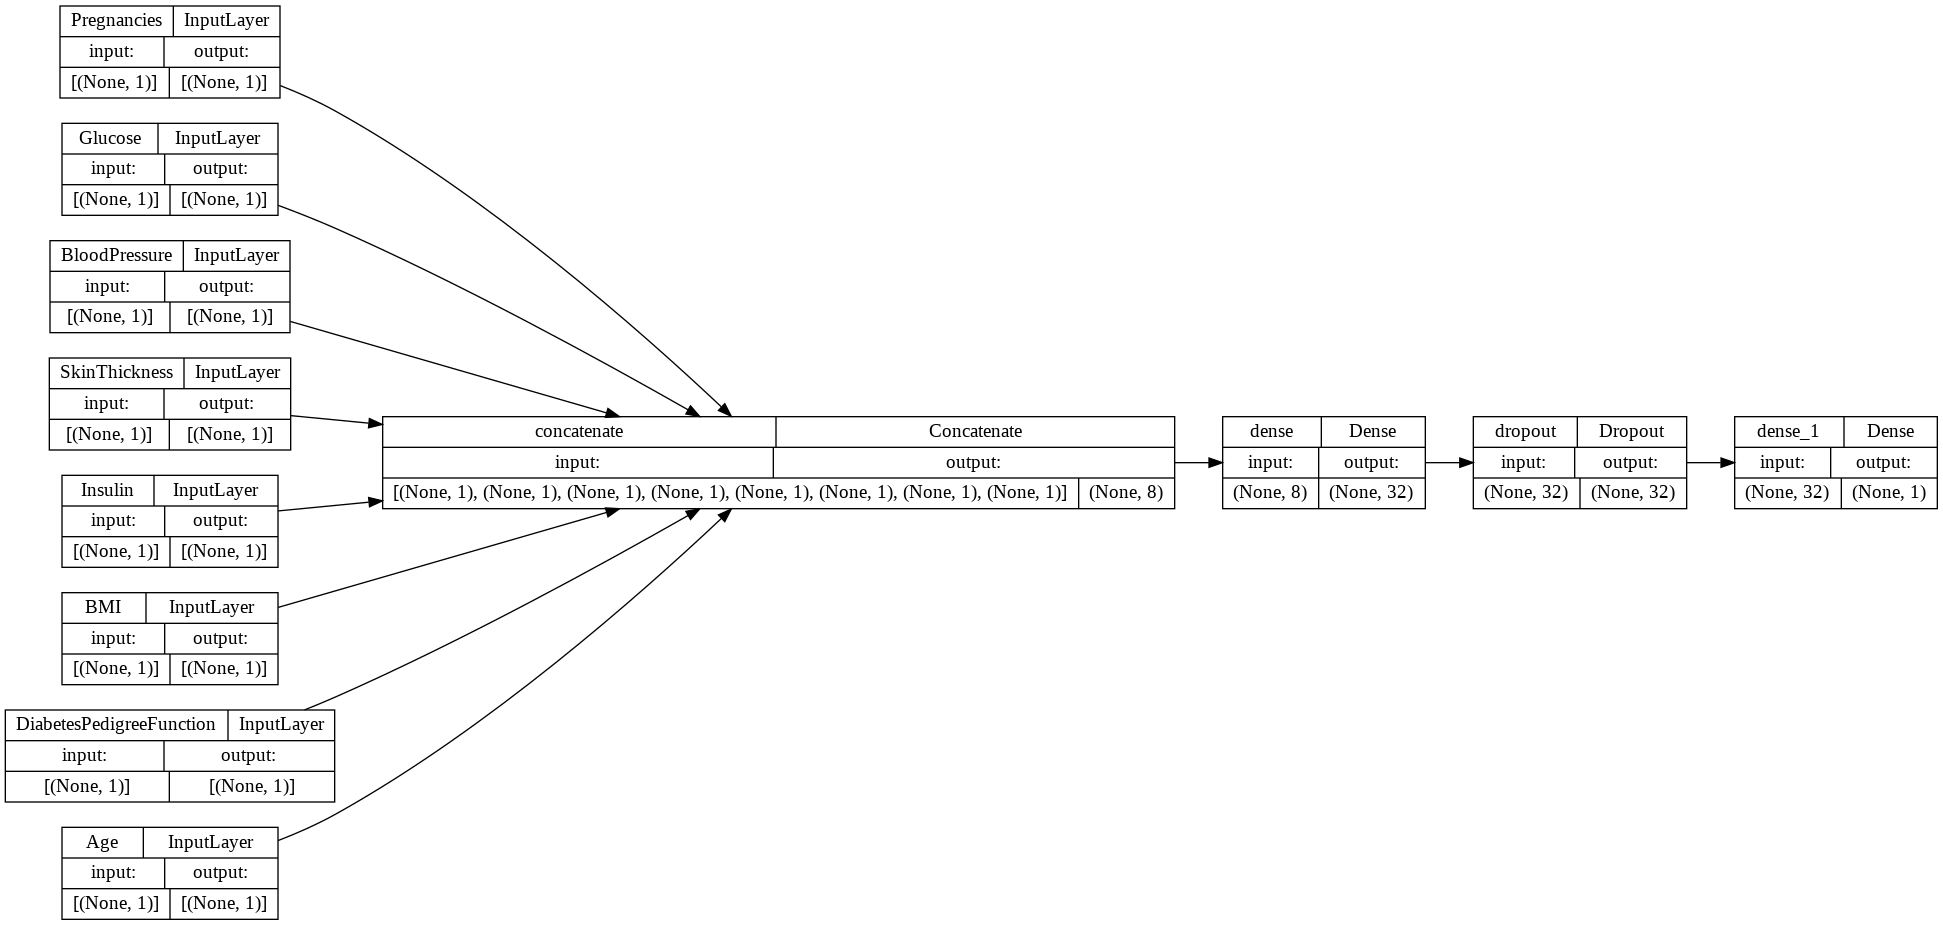

In [12]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Обучение модели по эпохам

In [13]:
model.fit(train_ds, epochs=120, validation_data=val_ds)

Epoch 1/120
20/20 [==============================] - 1s 11ms/step - loss: 30.7784 - accuracy: 0.5440 - val_loss: 8.5728 - val_accuracy: 0.7727
Epoch 2/120
20/20 [==============================] - 0s 3ms/step - loss: 23.8180 - accuracy: 0.5407 - val_loss: 5.2434 - val_accuracy: 0.7532
Epoch 3/120
20/20 [==============================] - 0s 3ms/step - loss: 20.1461 - accuracy: 0.5456 - val_loss: 3.6219 - val_accuracy: 0.7208
Epoch 4/120
20/20 [==============================] - 0s 3ms/step - loss: 18.6092 - accuracy: 0.5244 - val_loss: 3.2246 - val_accuracy: 0.7143
Epoch 5/120
20/20 [==============================] - 0s 3ms/step - loss: 20.4046 - accuracy: 0.5000 - val_loss: 3.2038 - val_accuracy: 0.7468
Epoch 6/120
20/20 [==============================] - 0s 3ms/step - loss: 17.1693 - accuracy: 0.5179 - val_loss: 2.8694 - val_accuracy: 0.7468
Epoch 7/120
20/20 [==============================] - 0s 3ms/step - loss: 14.5763 - accuracy: 0.5130 - val_loss: 2.1428 - val_accuracy: 0.7273
Epoch

По окончанию обучения модели на основе 120 эпох обучения, имеем точность предсказания 79,22%

# Проверка работоспособности модели

Рассмотрим произвольного человека с параметрами, соответствующими пациенту номер 57:
*   Беременность: отсутствует
*   Уровень глюкозы: 100
*   Кровяное давление: 88
*   Толщина кожи: 60
*   Уровень инсулина: 110
*   Индекс массы тела: 46.8
*   Функция наследственности заболевания: 0.962
*   Возраст: 31

In [21]:
sample = {
    "Pregnancies": 0,
    "Glucose": 100,
    "BloodPressure": 88,
    "SkinThickness": 60,
    "Insulin": 110,
    "BMI": 46.8,
    "DiabetesPedigreeFunction": 0.962,
    "Age": 31,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "Данный пациент имеет %.1f процентную вероятность "
    "наличия заболевания типа Диабет, согласно прогнозу нашей модели." % (100 * predictions[0][0],)
)

1/1 [==============================] - 0s 26ms/step
Данный пациент имеет 20.6 процентную вероятность наличия заболевания типа Диабет, согласно прогнозу нашей модели.
